# Trees

## Imports

In [1]:
import pandas as pd
from sqlalchemy import create_engine

server = "mssql-82792-0.cloudclusters.net:16272"
username = "user"
password = "RiceOwls1912" 
database = "ghz"
string = "mssql+pymssql://" + username + ":" + password + "@" + server + "/" + database

conn = create_engine(string).connect()


## EXAMPLE: TRAIN FROM 2021-12, PREDICT FOR 2022-01

In [3]:
df = pd.read_sql(
    """
    select ticker, date, agr, bm, idiovol, mom12m, roeq, ret
    from data
    where date in ('2021-12', '2022-01')
    """, 
    conn
)
features = ["agr", "bm", "idiovol", "mom12m", "roeq"]

## TRANSFORM EACH CROSS-SECTION

In [7]:
from sklearn.preprocessing import QuantileTransformer
qt = QuantileTransformer(output_distribution="normal")

def qtxs(d):
    x = qt.fit_transform(d)
    return pd.DataFrame(x, columns=d.columns, index=d.index)

df[features + ["ret"]] = df.groupby(
  "date", 
  group_keys=False
)[features + ["ret"]].apply(qtxs)

## FIT A REGRESSION TREE

In [6]:
from sklearn.tree import DecisionTreeRegressor

df = df.dropna()

Xtrain = df[df.date=='2021-12'][features]
ytrain = df[df.date=='2021-12']["ret"]

model = DecisionTreeRegressor(
  max_depth=3,
  random_state=0
)
model.fit(Xtrain, ytrain)

DecisionTreeRegressor(max_depth=3, random_state=0)

## VIEW THE REGRESSION TREE

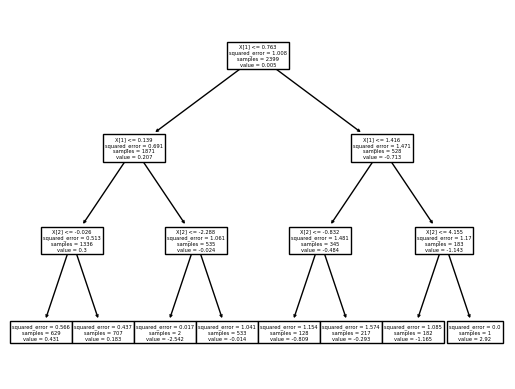

In [10]:
from sklearn.tree import plot_tree
_ = plot_tree(model)

## FEATURE IMPORTANCE

In [11]:
pd.Series(model.feature_importances_, index=Xtrain.columns)

bm         0.00000
idiovol    0.86057
mom12m     0.13943
roeq       0.00000
dtype: float64